# Notebook for calculating Attributes from given geometry files

As we are given the geometry files and basically the lattice type and vectors of the crystal structure which say nothing about the chemical environment in which the atoms of the crystal are situated. Therefore, it is necessary to calculate attributes which can describe the properties of the crystal or its structure.

Currently, as we have read from the literature it is important for the conductivity, that electronic orbitals of the metal atoms overlap. To do this, the surrounding of the metal atom should not be cluttered with oxygen atoms and have also
number of other metal atoms in its close proximity. At the same time it is important for the sake of the crystal stability that the metal atom is bonded to oxygen atom. The band gap can be in first approximation thought as the energy necessary to excite the electron from oxygen (which has obtained negative partial charge) to metal atom (which has positive partial charge). To take this into account we have calculated partial charges of the atoms with the electronegativity equalization method.[1] This method is modest both in its accuracy and computational time. Also this method gives us equilibrated electronegativity of the crystal.

Terms:

In order to find the coordination numbers (count of closest neighbours to given atom) it is necessary to construct radial distribution function profile

Partial charge - Charge on atom

[1] Bultinck, Patrick, et al. "The electronegativity equalization method I: Parametrization and validation for atomic charge calculations." The Journal of Physical Chemistry A 106.34 (2002): 7887-7894.

## Used packages

In [1]:
import ase.io
from ase.io import write
from ase import Atoms
from ase.visualize import view
from ase.units import Bohr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("error")

## Functions

In [2]:
#https://wiki.fysik.dtu.dk/asap/Radial%20Distribution%20Functions?action=AttachFile&do=get&target=RDF2.py
#https://wiki.fysik.dtu.dk/asap/Radial%20Distribution%20Functions#partial-rdfs-looking-at-specific-elements-or-subsets-of-atoms
# Helper function calculating coordination number from RDF
def getcoord(rdf, r, dens):
    # Find first peak by assuming it is the largest
    imax = rdf.argmax()
    # Find first minimum, assuming it is the deepest after the maximum.
    imin = imax + rdf[imax:].argmin()
#    print("Position of first peak and following minimum:", imax, imin)
    dr = r[1] - r[0]
    integral = 0.0
    for i in range(imin):
        integral += 4 * np.pi * r[i] * r[i] * dr * rdf[i]
    return integral * dens



#https://gitlab.com/ase/ase/blob/d752d69c6f18812e463bf83a0d77bbd8abb07330/ase/ga/utilities.py
#Commented out parts where their addition didn't seem reasonable
import math
#Function for calculating radial distribution function
def get_rdf(atoms, rmax, nbins, distance_matrix=None,
            elements=None, no_dists=False):
    """
    Returns two numpy arrays; the radial distribution function
    and the corresponding distances of the supplied atoms object.
    If no_dists = True then only the first array is returned.

    Parameters:

    rmax : float
        The maximum distance that will contribute to the rdf.

    nbins : int
        Number of bins to divide the rdf into.

    distance_matrix : numpy.array
        An array of distances between atoms, typically
        obtained by atoms.get_all_distances().
        Default None meaning that it will be calculated.

    elements : list or tuple
        List of two atomic numbers. If elements is not None the partial
        rdf for the supplied elements will be returned.

    no_dists : bool
        If True then the second array with rdf distances will not be returned
    """
    ##Calculate distances prepare axis
    dm = distance_matrix
    if dm is None:
        dm = atoms.get_all_distances()
    rdf = np.zeros(nbins + 1)
    dr = float(rmax / nbins)

    if elements is None:
        # Coefficients to use for normalization
        phi = len(atoms) / atoms.get_volume()
        norm = 4.0 * math.pi * dr * phi * len(atoms)

        #Find distances, each distance in list is covered once
        for i in range(len(atoms)):
            for j in range(i + 1, len(atoms)):
                rij = dm[i][j]
                index = int(math.ceil(rij / dr))
                if index <= nbins:
                    rdf[index] += 1
    else:
        #RDF will be found by principle how many atoms of 1 surround atom of 0
        i_indices = np.where(atoms.numbers == elements[0])[0]
        phi = len(i_indices) / atoms.get_volume()
        norm = 4.0 * math.pi * dr * phi * len(atoms)

        #Find distances
        for i in i_indices:
            for j in np.where(atoms.numbers == elements[1])[0]:
                rij = dm[i][j]
                index = int(math.ceil(rij / dr))
                if index <= nbins:
                    rdf[index] += 1

    dists = []
    for i in range(1, nbins + 1):
        rrr = (i - 0.5) * dr
        dists.append(rrr)
        # Normalize
        rdf[i] /= (norm * ((rrr**2)))# + (dr**2) / 12.))

    if no_dists:
        return rdf[1:]
    return rdf[1:], np.array(dists)


########### Vacuum Permitivity ##################

eps0 = 0.0055263494 # el/V/A
epsilon0 = 3.449276*10**16 #el^2/(Angs*J)

##################### IPs and EAs###########################

#https://en.wikipedia.org/wiki/Ionization_energies_of_the_elements_(data_page)
#https://en.wikipedia.org/wiki/Electron_affinity_(data_page)
#Electron affinities (Energy released when attracting electron)
EAs = {8:1.4611136 ,13:0.43283, 31:0.43, 49:0.38392} #eV
#Ionization potential (Energy necessary to remove an electron from atom)
IPs = {8:13.61806 ,13:5.98577, 31:5.99930, 49:5.78636 } #eV

#Give values in eV

#Measure of the tendency of an atom to attract electrons
def mullikenElectronegativity(EA, IP):
    return (EA+IP)/2
#Measure of the resistance of the atom to change in the electronic structure
def mullikenHardness(EA, IP):
    return (IP-EA)/2

#############################################################

# Load in data

In [3]:
#Create a dataframe where to save results
df = pd.DataFrame()

#Folders
homePath = os.getcwd()
os.chdir("train")
dirsToCalc = np.arange(1,2401,1)

# Calculations to construct features

The features to be constructed are:
 * Coordination number between pair of atoms
 * Smallest average distance between atoms of two kinds e.g. Al and O
 * Average partial charge of atom (e.g. Aluminium atom) in crystal
 * Equilibrated electronegativity of crystal
 * Volume per atom
 * Electrostatic interaction in unit cell

In [4]:
for i in dirsToCalc:

    os.chdir(str(i))
    ################# Load in Geometry

    name = i
    unitCell = ase.io.read("geometry.xyz", format="aims")

    elements = np.unique(unitCell.get_chemical_symbols())
    nrOfAtoms = []
    for j in elements:
        symbols = np.asarray(unitCell.get_chemical_symbols())
        nrOfAtoms+=[len(symbols[symbols==j])]

    ################# RDF, Coordination number, closest distances

    rng=10.0 #Range of profile in Angstroms
    bins = 200 #Number of bins to divide the profile
    rho = len(unitCell)/unitCell.get_volume() #Average density of unit cell atoms/Angstroms3

    #Apply the functions defined above for Al-O, In-O, Ga-O, Al-Ga, Ga-Al, Al-In, In-Al, Ga-In, In-Ga catching exception when atom is not in crystal
    try:
        rdfAlO, x = get_rdf(unitCell, rng, bins, elements=[13,8])
        cAlO = getcoord(rdfAlO, x, rho) #Find the coordination number of oxygens near Aluminium atom
        distAlO = x[rdfAlO.argmax()]
    except RuntimeWarning:
        cAlO = np.nan
        distAlO = np.nan
    try:
        rdfGaO, x = get_rdf(unitCell, rng, bins, elements=[31,8])
        cGaO = getcoord(rdfGaO, x, rho) #Find the coordination number of oxygens near Gallium atom
        distGaO = x[rdfGaO.argmax()]
    except RuntimeWarning:
        cGaO = np.nan
        distGaO = np.nan
    try:
        rdfInO, x = get_rdf(unitCell, rng, bins, elements=[49,8])
        cInO = getcoord(rdfInO, x, rho) #Find the coordination number of oxygens near Indium atom
        distGaO = x[rdfGaO.argmax()]
    except RuntimeWarning:
        cInO = np.nan
        distGaO = np.nan
    try:
        rdfAlGa, x = get_rdf(unitCell, rng, bins, elements=[13,31])
        cAlGa = getcoord(rdfAlGa, x, rho) #Find the coordination number of Gallium near Aluminium atom
        distAlGa = x[rdfAlGa.argmax()]
    except RuntimeWarning:
        cAlGa = np.nan
        distAlGa = np.nan
    try:
        rdfGaAl, x = get_rdf(unitCell, rng, bins, elements=[31,13])
        cGaAl = getcoord(rdfGaAl, x, rho) #Find the coordination number of Aluminium near Gallium atom
        distGaAl = x[rdfGaAl.argmax()]
    except RuntimeWarning:
        cGaAl = np.nan
        distGaAl = np.nan
    try:
        rdfAlIn, x = get_rdf(unitCell, rng, bins, elements=[13,49])
        cAlIn = getcoord(rdfAlIn, x, rho) #Find the coordination number of Indium near Aluminium atom
        distAlIn = x[rdfAlIn.argmax()]
    except RuntimeWarning:
        cAlIn = np.nan
        distAlIn = np.nan
    try:
        rdfInAl, x = get_rdf(unitCell, rng, bins, elements=[49,13])
        cInAl = getcoord(rdfInAl, x, rho) #Find the coordination number of Aluminium near Indium atom
        distInAl = x[rdfInAl.argmax()]
    except RuntimeWarning:
        cInAl = np.nan
        distInAl = np.nan
    try:
        rdfGaIn, x = get_rdf(unitCell, rng, bins, elements=[31,49])
        cGaIn = getcoord(rdfGaIn, x, rho) #Find the coordination number of Indium atoms near Gallium atom
        distGaIn = x[rdfGaIn.argmax()]
    except RuntimeWarning:
        cGaIn = np.nan
        distGaIn = np.nan
    try:
        rdfInGa, x = get_rdf(unitCell, rng, bins, elements=[49,31])
        cInGa = getcoord(rdfInGa, x, rho) #Find the coordination number of Gallium atoms near Indium atom
        distInGa = x[rdfInGa.argmax()]
    except RuntimeWarning:
        cInGa = np.nan
        distInGa = np.nan


    ############# The calculation of partial charge of atom by using The Electronegativity Equalization Method

    ##### Formula taken from: Bultinck, Patrick, et al. 
    #"The electronegativity equalization method I: Parametrization and validation for atomic charge calculations." 
    #The Journal of Physical Chemistry A 106.34 (2002): 7887-7894.

    #Construct the matrix for charge calculation
    try:
        matrix = 1/(np.asarray(unitCell.get_all_distances())) #1/Angstroms
    except RuntimeWarning:
        warnings.filterwarnings("once")
        matrix = 1/(np.asarray(unitCell.get_all_distances())) #1/Angstroms

    atomnumbers = unitCell.numbers
    for j in range(len(matrix)):
        matrix[j][j] = 2*mullikenHardness(EAs[atomnumbers[j]],IPs[atomnumbers[j]])

    #Add extra row
    matrix = np.vstack((matrix, np.zeros(len(matrix[0]))+1)) 

    #Add extra column
    extraColumn = np.zeros(len(matrix))-1
    extraColumn[-1] = 0

    matrix = np.column_stack((matrix, extraColumn)) 

    #Result column is -electronegativity by theory + total charge of system
    resultColumn = []
    for j in range(len(atomnumbers)):
        resultColumn+=[-1*mullikenElectronegativity(EAs[atomnumbers[j]],IPs[atomnumbers[j]])]
    resultColumn+=[0] #This is total charge of system

    #Solve the matrix equation
    #Last member is equilibrated electronegativity, others are charges of respective atoms
    x = np.linalg.solve(matrix, resultColumn)

    eqEn = x[-1] #Equilibrated electronegativity
    charges = x[:-1] #Atomic charges calculated

    #Mean charges of atom kind
    AlCharge = np.mean(charges[unitCell.numbers==13])
    GaCharge = np.mean(charges[unitCell.numbers==31])
    InCharge = np.mean(charges[unitCell.numbers==49])
    OCharge = np.mean(charges[unitCell.numbers==8])

    ################## Estimate electrostatic interaction in unit cell

    #Estimate the electrostatic interaction between atoms in unit cell (is there more attraction or repulsion)
    #For each atom calculate its electrostatic interaction with other atoms
    electrostaticIntCell = 0
    distanceMatrix = unitCell.get_all_distances()
    for k in range(len(charges)):
        for l in range(len(charges)):
            if(k!=l):
                electrostaticIntCell+=1/(4*np.pi*epsilon0)*charges[k]*charges[l]/distanceMatrix[k][l]
    #Divide the result by two so we won't count one iteraction two times
    # Unit is be kJ/mol - Kilojoules per 1 mole of crystal atoms
    electrostaticIntCell = electrostaticIntCell/2/len(unitCell)/1000*6.02*10**23 
        
    #Volume per atom [A^3]
    atomVolume = unitCell.get_volume()/len(unitCell)

    #Append collected data to dataframe

    df = df.append({ "Nr":i,"cAlO":cAlO, "cGaO":cGaO, "cInO":cInO, "cAlGa":cAlGa, "cGaAl":cGaAl, "cAlIn":cAlIn, "cInAl":cInAl,
                   "cGaIn":cGaIn, "cInGa":cInGa, "distAlO":distAlO, "distGaO":distGaO, "distAlGa":distAlGa, "distGaAl":distGaAl,
                   "distAlIn":distAlIn, "distInAl":distInAl, "distGaIn":distGaIn, "distInGa":distInGa,
                   "xEq":eqEn, "qAl":AlCharge, "qGa":GaCharge, "qIn":InCharge, "qO":OCharge, "Vatom":atomVolume, "elInt":electrostaticIntCell}, ignore_index=True)
    os.chdir("..")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in double_scalars


In [5]:
df

,Nr,Vatom,cAlGa,cAlIn,cAlO,cGaAl,cGaIn,cGaO,cInAl,cInGa,...,distGaIn,distGaO,distInAl,distInGa,elInt,qAl,qGa,qIn,qO,xEq
0,1.0,9.763082,2.200000,0.000000,3.650000,3.666667,0.000000,3.416667,NaN,NaN,...,0.025,NaN,NaN,NaN,-41.086176,0.349004,0.345264,NaN,-0.231734,4.896453
1,2.0,9.781193,1.150000,0.000000,3.100000,1.916667,0.000000,1.166667,0.000000,0.000000,...,0.025,1.775,0.025,0.025,-38.554098,0.344690,0.347084,NaN,-0.230392,4.905702
2,3.0,9.780743,0.538462,0.000000,2.769231,2.333333,0.000000,1.666667,0.000000,0.000000,...,0.025,1.825,0.025,0.025,-33.957596,0.343019,0.339820,NaN,-0.228280,4.925995
3,4.0,9.779173,0.000000,0.555556,3.222222,0.000000,0.000000,0.000000,1.666667,0.000000,...,0.025,0.025,2.925,0.025,-35.763321,0.337616,NaN,0.375759,-0.231435,4.898196
4,5.0,11.808965,0.000000,0.000000,0.000000,0.000000,2.150000,3.000000,0.000000,3.583333,...,3.625,2.025,0.025,3.625,-36.645650,NaN,0.342521,0.359175,-0.232511,4.869110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,2396.0,9.599034,1.250000,0.000000,3.333333,3.750000,0.000000,2.500000,0.000000,0.000000,...,0.025,1.775,0.025,0.025,-39.262887,0.346869,0.345489,NaN,-0.231016,4.905482
2396,2397.0,9.515230,2.400000,0.000000,3.400000,1.714286,0.000000,3.285714,0.000000,0.000000,...,0.025,2.025,0.025,0.025,-35.323868,0.345140,0.342118,NaN,-0.228918,4.928134
2397,2398.0,9.797481,2.357143,0.000000,6.000000,1.833333,0.000000,3.000000,0.000000,0.000000,...,0.025,1.975,0.025,0.025,-38.566520,0.364599,0.330046,NaN,-0.230109,4.873503
2398,2399.0,11.773623,0.900000,1.500000,2.800000,1.500000,2.166667,3.166667,0.937500,0.812500,...,3.525,2.125,3.375,3.525,-39.874295,0.335601,0.329533,0.372616,-0.235314,4.842888


In [ ]:
#Save Dataframe to csv
os.chdir(homePath)
df.to_csv("additionalAttributes.csv")

7.347222222222225

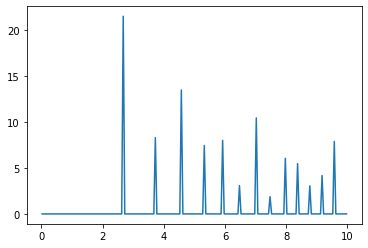

In [9]:

#################### Testing ###################

from ase.lattice.compounds import *

atoms = Atoms(L1_2(size=(12,12,12), symbol=("Au", "Cu"), pbc=True,
             latticeconstant=3.75))

# We want RDF out to a distance of 15 Angstrom, with 200 bins
rng=10.0
bins = 200

rdf, x = get_rdf(atoms, rng, bins, elements=[29,29])
plt.plot(x, rdf)

rho = len(atoms)/atoms.get_volume()
cAuCu = getcoord(rdf, x, rho)# / (len(np.where(atoms.numbers == 79)[0])/len(atoms))
cAuCu


In [10]:
len(atoms)

6912